In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ada_csl_wrc.evaluation import evaluate

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

from ada_csl_wrc.models import CostSensitiveDecisionTreeClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from ada_csl_wrc.models import ConstrainedCSDecisionTree
from ada_csl_wrc.models import Constrained
from sklearn.model_selection import train_test_split
from ada_csl_wrc.utils import prediction_up_to_constraint
import pandas as pd
from ada_csl_wrc.utils import prepare_for_cost_cle
from ada_csl_wrc.utils import filter_only_worst_features
from ada_csl_wrc.utils import find_effective_threshold
from tqdm import tqdm
import json

from typing import Union
from itertools import product 
import time


loaded ada_csl_wrc.utils


### Hyperparameters of the experiment

In [7]:
COST_FALSE_NEGATIVE = 10
COST_FALSE_POSITIVE = 1
t = COST_FALSE_POSITIVE/(COST_FALSE_POSITIVE+COST_FALSE_NEGATIVE)
COST_MATRIX = np.array([[0, COST_FALSE_POSITIVE], [COST_FALSE_NEGATIVE, 0]])

### Data-specific code

This part includes some data-specific code. It is not included in the final model. <br>
The X and the y are the dataframes that are used for training and testing.

In [8]:
df = pd.read_csv('./data/marketing_campaign.csv', sep=";")
df = df.drop(['Z_CostContact', 'Z_Revenue', 'Income', 'Dt_Customer', 'ID'], axis = 1)
full_X = df.drop(labels = 'Response', axis=1)
y = df['Response']

#Transforming categorial features into numerical
categorial_col = full_X.select_dtypes(include='object').columns
full_X[categorial_col] = full_X[categorial_col].astype('category').apply(lambda x: x.cat.codes)

In [9]:
def find_best_params(param_grid, X, y):
    # Used for this dataset specifically, to find the best parameters for the decision tree
    # Let's think about more general way to do so.
    grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, n_jobs=-1, scoring='f1', verbose=3)
    grid.fit(X, y)
    return grid.best_params_

In [10]:
dt_param_grid = {
    "max_depth": [3, 5, 10, 15],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [10, 15, 20, 30]
}

cs_best_params = json.load(open("./config/cost_sensitive_best_params.json", "r")) #hard-coded in a json file
#dt_best_params = find_best_params(dt_param_grid, X, y) #find it using grid search
dt_best_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}

If you have reached here, it means that you have in memory the dt_best_params and cs_best_params. <br>
We will inititate our base-classifier based on these params. However, the results of the experiment might be affected by this choice. <br>

## Starting the experiment

In [11]:
real_positive_ratio = y.mean()

In [12]:
constraints_range = np.array([0.25, 0.75]) * real_positive_ratio
test_size = round(len(X)/3)
constraints_range = np.round(constraints_range * test_size).astype(int)
constraints = np.arange(*constraints_range)

### Decision Tree
With best params from the grid search, applying on various of constraints

In [13]:
def run_constrained_experiment(constrained_model:Constrained, 
                               X: np.ndarray, 
                               y: np.ndarray, 
                               cost_matrix: np.ndarray, 
                               constraint: Union[float, int], 
                               random_state=42, 
                               n_splits=3):

    fit_params = {}
    out = {}
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for (fold, (train_index, test_index)) in enumerate(kf.split(X, y)):
        #The ordinary Kfold, but with the constraint
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if isinstance(constrained_model.model, CostSensitiveDecisionTreeClassifier):
            #The Cost Sensitive Decision Tree also needs the cost matrix as a fit parameter
            fit_params['cost_mat'] = prepare_for_cost_cle(len(X_train), cost_matrix)

        constrained_model.fit(X_train, y_train, **fit_params) #Fitting the model

        #The constraint is a float between 0 and 1
        y_pred = constrained_model.predict_constrained(X_test, constraint=constraint)
        
        out[fold] = evaluate(y_test, y_pred, cost_matrix)
    

    return pd.DataFrame(out).T.mean(axis=0).to_dict() #Returning the mean of the metrics

In [138]:
worst_feature_ratio_grid = [1.0, 0.75, 0.5]
constraints_grid = constraints
random_state_grid = range(2)
base_models_grid = [
    CostSensitiveDecisionTreeClassifier(**cs_best_params), 
    DecisionTreeClassifier(**dt_best_params)
    ]
experiment_grid = product(worst_feature_ratio_grid, constraints_grid, random_state_grid, base_models_grid)
experiment_grid = list(experiment_grid)
pbar = tqdm(experiment_grid, total=len(experiment_grid))

results = []
for (worst_feature_ratio, constraint, random_state, base_model) in pbar:

    #adding tqdm information
    pbar.set_description(f"worst_feature_ratio: {worst_feature_ratio}, constraint: {constraint}, random_state: {random_state}, model: {base_model.__class__.__name__}")
    

    X = filter_only_worst_features(full_X, y, worst_feature_ratio)
    partial_results = run_constrained_experiment(Constrained(base_model), X.values, y.values, COST_MATRIX, constraint, random_state=random_state)
    partial_results['worst_feature_ratio'] = worst_feature_ratio
    partial_results['constraint'] = constraint
    partial_results['random_state'] = random_state
    partial_results['model'] = base_model.__class__.__name__
    results.append(partial_results)
    #Setting suffix to tqdm

worst_feature_ratio: 1.0, constraint: 83, random_state: 1, model: DecisionTreeClassifier: 100%|██████████| 672/672 [2:03:19<00:00, 11.01s/it]                  


,worst_feature_ratio,constraint,model,cost,accuracy,precision,recall,f1
224,1.0,28,CostSensitiveDecisionTreeClassifier,1088.166667,0.826336,0.172619,0.043383,0.069339
225,1.0,28,DecisionTreeClassifier,912.166667,0.869194,0.744048,0.187111,0.299024
226,1.0,29,CostSensitiveDecisionTreeClassifier,1087.333333,0.825443,0.172414,0.044871,0.071209
227,1.0,29,DecisionTreeClassifier,907.666667,0.869194,0.735632,0.191602,0.304019
228,1.0,30,CostSensitiveDecisionTreeClassifier,1086.500000,0.824551,0.172222,0.046372,0.073070
...,...,...,...,...,...,...,...,...
331,1.0,81,DecisionTreeClassifier,717.666667,0.858478,0.534979,0.389211,0.450597
332,1.0,82,CostSensitiveDecisionTreeClassifier,1032.166667,0.780797,0.180894,0.133191,0.153420
333,1.0,82,DecisionTreeClassifier,715.000000,0.858031,0.532520,0.392200,0.451712
334,1.0,83,CostSensitiveDecisionTreeClassifier,1027.666667,0.780797,0.184739,0.137682,0.157776


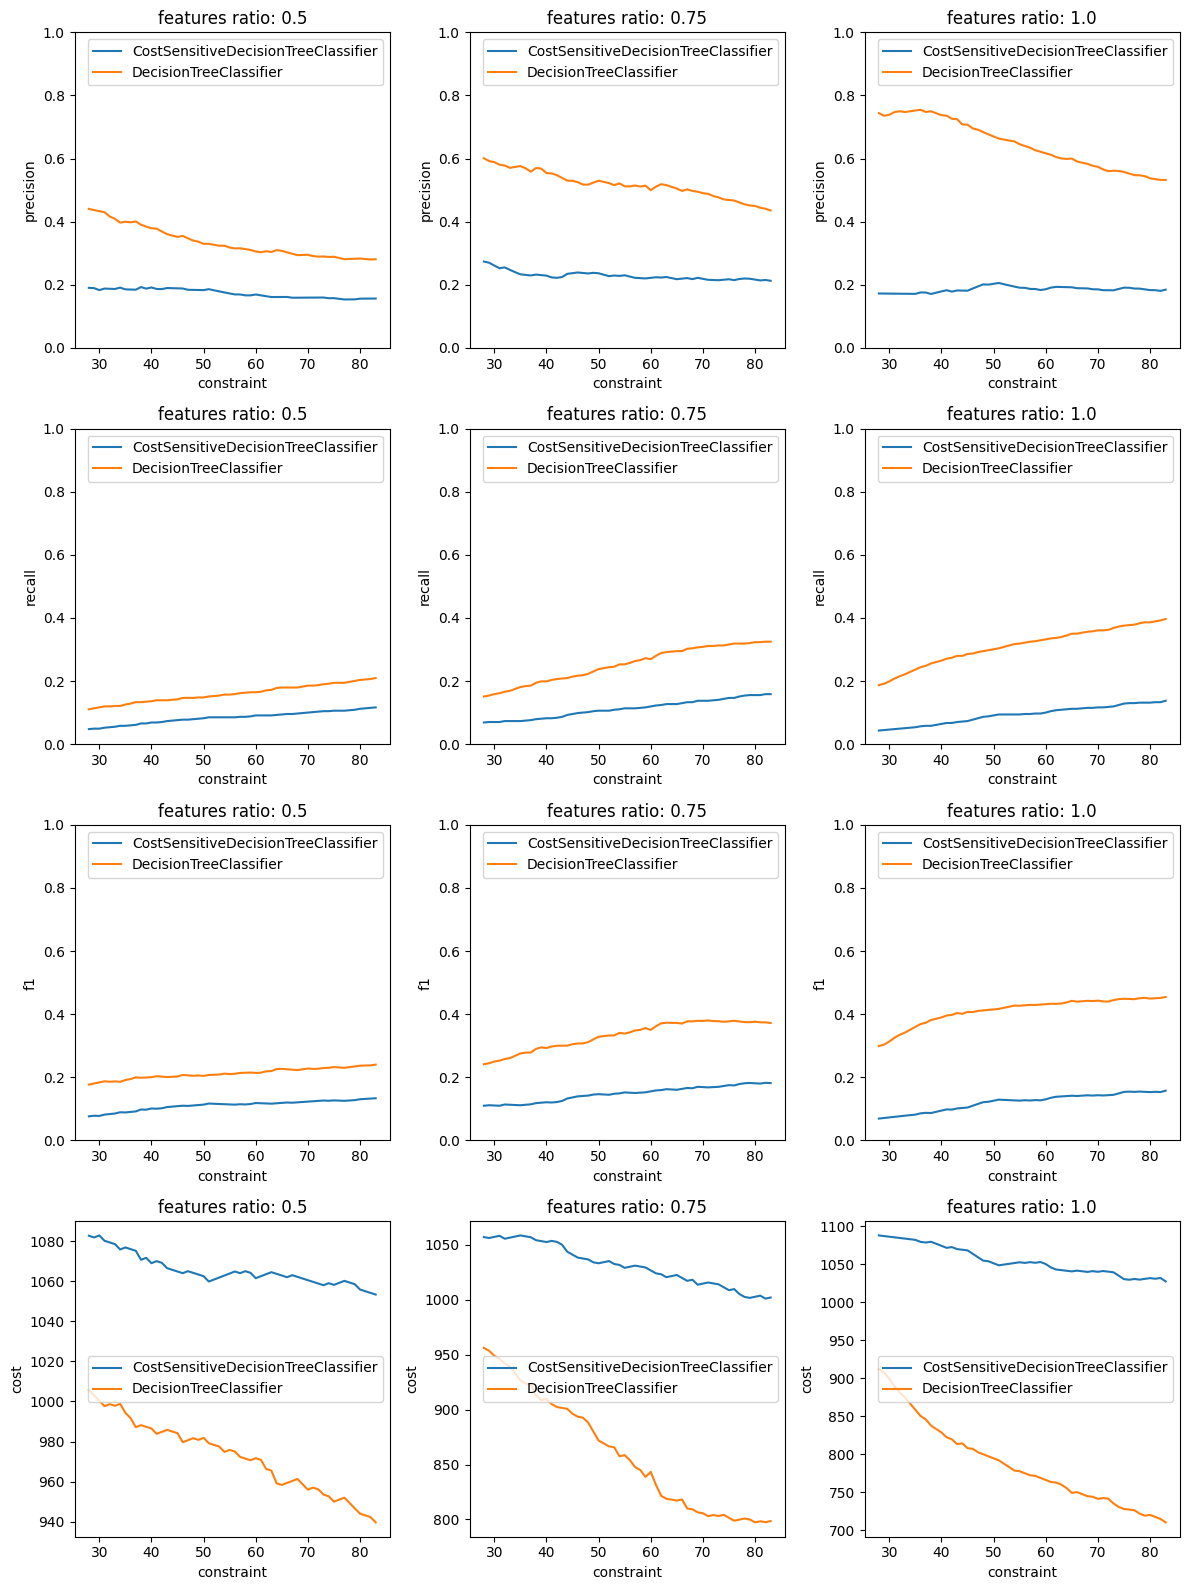

In [178]:
my_results = pd.DataFrame(results)
my_results = my_results.groupby(['worst_feature_ratio', 'constraint', 'model'], as_index=False).mean().drop("random_state", axis=1)
metrics = ['precision', 'recall', 'f1', 'cost']
my_results
#create subplots

ncols = len(worst_feature_ratio_grid)
nrows = len(metrics)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
for (i, metric) in enumerate(metrics):
    for (j, worst_feature_ratio) in enumerate(worst_feature_ratio_grid):
        ax = axes[i, j]
        sub_results = my_results[my_results['worst_feature_ratio'] == worst_feature_ratio]
        sub_results.set_index("constraint").groupby("model")[metric].plot(ax=ax, legend=True)
        #adding ylabel
        ax.set_ylabel(metric)
        ax.legend()
        #adding title
        ax.set_title(f"features ratio: {worst_feature_ratio}")
        if metric!="cost":
            ax.set_ylim(0, 1)

        ax.set_xlabel("constraint")
fig.tight_layout()
sub_results


In [206]:
#Running the experiment for our model takes too long, but here is peek of how it works.

CONSTRAINT = 35 / (len(X) /3) 
FEATURES_RATIO = 1.0


def run_our_experiment(
        X, 
        y, 
        cost_matrix, 
        constraint, 
        random_state=42, 
        n_splits=3, **model_params):
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cfn = cost_matrix[1,0]
    out = {}

    for (fold, (train_index, test_index)) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = ConstrainedCSDecisionTree(constraint=constraint, **model_params)
        model.fit(X_train, y_train, cfn=cfn)
        y_pred = model.predict(X_test)
        out[fold] = evaluate(y_test, y_pred, cost_matrix)

    return pd.DataFrame(out).T.mean(axis=0)

#ConstrainedCSDecisionTree(constraint=0.5).fit(X_train, y_train, cfn=10)
X = filter_only_worst_features(full_X, y, FEATURES_RATIO)

out = []
for i in range(3):
    peek = run_our_experiment(X.values, y.values, cost_matrix=COST_MATRIX, constraint=CONSTRAINT, random_state=i, **cs_best_params)
    out.append(peek)
pd.DataFrame(out).mean(axis=0)

Threshold: 0.52 Effective Threshold: 0.64 Cost False Positive: 11.23 Lower Bound: 10.74 Upper Bound: 11.7200
DONE
Threshold: 0.53
Effective threshold: 0.53
Current cfp:  10.986328125
Lower bound:  10.7421875
Upper bound:  11.23046875
Threshold: 0.49 Effective Threshold: 0.63 Cost False Positive: 9.64 Lower Bound: 9.52 Upper Bound: 9.7722000
DONE
Threshold: 0.49
Effective threshold: 0.49
Current cfp:  9.58251953125
Lower bound:  9.521484375
Upper bound:  9.6435546875
Threshold: 0.49 Effective Threshold: 0.49 Cost False Positive: 8.79 Lower Bound: 7.81 Upper Bound: 9.7722000
DONE
Threshold: 0.47
Effective threshold: 0.47
Current cfp:  8.30078125
Lower bound:  7.8125
Upper bound:  8.7890625
Threshold: 0.49 Effective Threshold: 0.49 Cost False Positive: 8.79 Lower Bound: 7.81 Upper Bound: 9.7722000
DONE
Threshold: 0.47
Effective threshold: 0.47
Current cfp:  8.30078125
Lower bound:  7.8125
Upper bound:  8.7890625
Threshold: 0.49 Effective Threshold: 0.62 Cost False Positive: 10.74 Lower Bo